# T1/T2 MRI CycleGAN s U-Net Generatorima

Ova bilježnica implementira CycleGAN model za transformaciju između T1 i T2 MRI snimaka. Koristi U-Net arhitekturu za generatore kako bi se postigli bolji rezultati u očuvanju strukture.

In [1]:
!nvidia-smi


Thu May  8 17:54:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...    Off |   00000000:01:00.0  On |                  N/A |
| N/A   36C    P5             18W /   80W |     525MiB /   6144MiB |     32%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1. Postavljanje okruženja i uvoz bibliteka

In [2]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
import torch.backends.cudnn as cudnn
from PIL import Image
from skimage.metrics import structural_similarity as ssim
from sklearn.model_selection import train_test_split
import datetime
import json

# Postavljanje random seed-a za reproducibilnost
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    # Omogućavanje CUDNN benchmarkinga za brže treniranje
    cudnn.benchmark = True
# Provjera dostupnosti GPU-a
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Koristim uređaj: {device}")
# Ako je dostupan CUDA, ispiši informacije o GPU-u
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memorija: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


Koristim uređaj: cuda
GPU: NVIDIA GeForce RTX 3060 Laptop GPU
Memorija: 6.19 GB


In [3]:
import sys
import os
sys.path.append(os.path.abspath('..'))

from utils.models import UNetGenerator
from utils.config import CycleGANConfig
from utils.dataset import get_stratified_data_loaders
from utils.train import train_cyclegan
from utils.test import test_model
from utils.visualization import visualize_results, plot_training_curves


In [4]:
config = CycleGANConfig(
    t1_dir="../dataset/data/images/t1",  # Prilagodite putanju prema vašim podacima
    t2_dir="../dataset/data/images/t2",  # Prilagodite putanju prema vašim podacima
    results_dir="../rezultati/standard_model",
    checkpoints_dir="../checkpoints/standard_model",
    batch_size=4,  # Smanjite za manje GPU memorije
    lr=0.0002,
    beta1=0.5,
    beta2=0.999,
    n_epochs=150,  # Prilagodite broj epoha prema potrebi
    decay_epoch=50,  # Learning rate počinje opadati nakon ove epohe
    img_size=256,
    input_channels=1,  # MRI slike su sive (1 kanal)
    output_channels=1,
    ngf=64,  # Broj filtera u generatoru
    ndf=64,  # Broj filtera u diskriminatoru
    lambda_A=10.0,  # Težina cycle loss-a za T1->T2->T1
    lambda_B=10.0,  # Težina cycle loss-a za T2->T1->T2
    lambda_identity=0.5,  # Težina identity loss-a
    architecture="standard",  # Koristimo standardnu arhitekturu
    sample_interval=50,  # Vizualiziraj slike svakih 5 epoha
    checkpoint_interval=50,  # Spremi checkpoint svakih 10 epoha
    device=None  # Automatski odabir (GPU ako je dostupan, inače CPU)
)

In [5]:
# Ispiši konfiguraciju
config.print_config()


=== Konfiguracija modela ===
Arhitektura: standard
T1 direktorij: ../dataset/data/images/t1
T2 direktorij: ../dataset/data/images/t2
Batch veličina: 4
Learning rate: 0.0002
Broj epoha: 150
Veličina slike: 256x256
Broj filtera u generatoru: 64
Broj filtera u diskriminatoru: 64
Lambda A: 10.0
Lambda B: 10.0
Lambda identity: 0.5
Uređaj: cuda



In [6]:
# Lista posebnih ID-ova za stratificiranu podjelu (ID-ovi "mutnijih" slika)
special_ids = [
    '035', '230', '231', '232', '233', '234', '238', '290', '291', '292', 
    '293', '294', '303', '305', '306', '307', '310', '314', '315', '322', 
    '331', '332', '333', '337', '340', '345', '347', '371', '372', '373', 
    '378', '382', '388', '395', '423', '424', '425', '426', '427', '430', 
    '433', '434', '435', '442', '462', '463', '464', '469', '470', '473', 
    '474', '475', '476', '477', '478', '510', '517', '532', '541', '542', 
    '543', '547', '548', '553', '561', '563', '571', '573', '574', '588', 
    '595', '596', '597'
]

print(f"Broj posebnih ID-ova: {len(special_ids)}")

train_dataloader, val_dataloader, test_dataloader = get_stratified_data_loaders(
    config=config,
    special_ids=special_ids,
    train_ratio=0.8,
    val_ratio=0.05,
    test_ratio=0.15
)

Broj posebnih ID-ova: 73
Pronađeno 572 T1 slika i 572 T2 slika
Pronađeno 572 sparenih T1/T2 slika
Pronađeno 69 posebnih slika i 503 regularnih slika.
Podjela posebnih slika: 55 trening, 3 validacija, 11 test
Podjela regularnih slika: 402 trening, 25 validacija, 76 test
Ukupna podjela: 457 trening, 28 validacija, 87 test


In [7]:
G_AB, G_BA, train_history, best_val_loss = train_cyclegan(
    config=config,
    use_test_split=True,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    test_dataloader=test_dataloader
)

Epoha 1/150: 100%|██████████| 115/115 [00:34<00:00,  3.29it/s, D_A_loss=0.2937, D_B_loss=0.1917, G_loss=2.5241]


Epoha 1/150 - Train gubici: G: 8.7145, D_A: 0.4470, D_B: 0.5549 | Val gubici: G: 2.0155, Cycle: 1.4223
Novi najbolji validacijski gubitak: 1.4223, spremam modele...


Epoha 2/150: 100%|██████████| 115/115 [00:30<00:00,  3.83it/s, D_A_loss=0.3611, D_B_loss=0.2116, G_loss=2.3507]


Epoha 2/150 - Train gubici: G: 2.5350, D_A: 0.2488, D_B: 0.2015 | Val gubici: G: 1.9448, Cycle: 1.1509
Novi najbolji validacijski gubitak: 1.1509, spremam modele...


Epoha 3/150: 100%|██████████| 115/115 [00:29<00:00,  3.89it/s, D_A_loss=0.1973, D_B_loss=0.2005, G_loss=2.4352]


Epoha 3/150 - Train gubici: G: 2.0672, D_A: 0.2524, D_B: 0.2391 | Val gubici: G: 1.9167, Cycle: 1.1259
Novi najbolji validacijski gubitak: 1.1259, spremam modele...


Epoha 4/150: 100%|██████████| 115/115 [00:29<00:00,  3.89it/s, D_A_loss=0.2731, D_B_loss=0.2860, G_loss=1.7626]


Epoha 4/150 - Train gubici: G: 1.9180, D_A: 0.2532, D_B: 0.2413 | Val gubici: G: 1.6081, Cycle: 0.9219
Novi najbolji validacijski gubitak: 0.9219, spremam modele...


Epoha 5/150: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2808, D_B_loss=0.2414, G_loss=1.6948]


Epoha 5/150 - Train gubici: G: 1.8199, D_A: 0.2502, D_B: 0.2495 | Val gubici: G: 1.4789, Cycle: 0.9477


Epoha 6/150: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2638, D_B_loss=0.2134, G_loss=1.5678]


Epoha 6/150 - Train gubici: G: 1.7760, D_A: 0.2576, D_B: 0.2404 | Val gubici: G: 1.4494, Cycle: 0.7620
Novi najbolji validacijski gubitak: 0.7620, spremam modele...


Epoha 7/150: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2825, D_B_loss=0.1933, G_loss=1.5583]


Epoha 7/150 - Train gubici: G: 1.7186, D_A: 0.2524, D_B: 0.2458 | Val gubici: G: 1.4937, Cycle: 0.9408


Epoha 8/150: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2342, D_B_loss=0.3099, G_loss=1.5090]


Epoha 8/150 - Train gubici: G: 1.6455, D_A: 0.2557, D_B: 0.2392 | Val gubici: G: 1.7043, Cycle: 0.7822


Epoha 9/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.3758, D_B_loss=0.1505, G_loss=1.5653]


Epoha 9/150 - Train gubici: G: 1.6417, D_A: 0.2589, D_B: 0.2468 | Val gubici: G: 1.7425, Cycle: 0.9291


Epoha 10/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1856, D_B_loss=0.2125, G_loss=1.6034]


Epoha 10/150 - Train gubici: G: 1.5864, D_A: 0.2492, D_B: 0.2330 | Val gubici: G: 1.6408, Cycle: 1.0159


Epoha 11/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.2174, D_B_loss=0.2280, G_loss=1.3054]


Epoha 11/150 - Train gubici: G: 1.6094, D_A: 0.2613, D_B: 0.2316 | Val gubici: G: 1.2475, Cycle: 0.7461
Novi najbolji validacijski gubitak: 0.7461, spremam modele...


Epoha 12/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.2135, D_B_loss=0.1488, G_loss=1.2479]


Epoha 12/150 - Train gubici: G: 1.5521, D_A: 0.2556, D_B: 0.2292 | Val gubici: G: 1.2767, Cycle: 0.6692
Novi najbolji validacijski gubitak: 0.6692, spremam modele...


Epoha 13/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.2001, D_B_loss=0.2516, G_loss=1.5206]


Epoha 13/150 - Train gubici: G: 1.5442, D_A: 0.2466, D_B: 0.2304 | Val gubici: G: 1.4538, Cycle: 0.8455


Epoha 14/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.3587, D_B_loss=0.2747, G_loss=1.5840]


Epoha 14/150 - Train gubici: G: 1.5819, D_A: 0.2504, D_B: 0.2234 | Val gubici: G: 1.4757, Cycle: 0.6625
Novi najbolji validacijski gubitak: 0.6625, spremam modele...


Epoha 15/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.2507, D_B_loss=0.1748, G_loss=1.2844]


Epoha 15/150 - Train gubici: G: 1.5172, D_A: 0.2584, D_B: 0.2324 | Val gubici: G: 1.3526, Cycle: 0.6679


Epoha 16/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.2095, D_B_loss=0.2257, G_loss=1.5274]


Epoha 16/150 - Train gubici: G: 1.4747, D_A: 0.2427, D_B: 0.2309 | Val gubici: G: 1.1971, Cycle: 0.7748


Epoha 17/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.2507, D_B_loss=0.3161, G_loss=1.2140]


Epoha 17/150 - Train gubici: G: 1.4728, D_A: 0.2573, D_B: 0.2342 | Val gubici: G: 1.4036, Cycle: 0.7413


Epoha 18/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.2331, D_B_loss=0.2581, G_loss=1.7474]


Epoha 18/150 - Train gubici: G: 1.4794, D_A: 0.2540, D_B: 0.2247 | Val gubici: G: 1.4338, Cycle: 0.9074


Epoha 19/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.2389, D_B_loss=0.4004, G_loss=1.4401]


Epoha 19/150 - Train gubici: G: 1.4659, D_A: 0.2498, D_B: 0.2314 | Val gubici: G: 1.3878, Cycle: 0.6743


Epoha 20/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1858, D_B_loss=0.0845, G_loss=1.3540]


Epoha 20/150 - Train gubici: G: 1.4483, D_A: 0.2580, D_B: 0.2178 | Val gubici: G: 1.3588, Cycle: 0.8806


Epoha 21/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1934, D_B_loss=0.2241, G_loss=1.5158]


Epoha 21/150 - Train gubici: G: 1.4488, D_A: 0.2475, D_B: 0.2235 | Val gubici: G: 1.2375, Cycle: 0.7151


Epoha 22/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.2231, D_B_loss=0.2756, G_loss=1.1941]


Epoha 22/150 - Train gubici: G: 1.4366, D_A: 0.2722, D_B: 0.2105 | Val gubici: G: 1.8454, Cycle: 0.7786


Epoha 23/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.2393, D_B_loss=0.2740, G_loss=1.4283]


Epoha 23/150 - Train gubici: G: 1.4268, D_A: 0.2479, D_B: 0.2241 | Val gubici: G: 1.3040, Cycle: 0.6408
Novi najbolji validacijski gubitak: 0.6408, spremam modele...


Epoha 24/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1429, D_B_loss=0.2845, G_loss=1.3754]


Epoha 24/150 - Train gubici: G: 1.4128, D_A: 0.2503, D_B: 0.2144 | Val gubici: G: 1.8706, Cycle: 1.2035


Epoha 25/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.2744, D_B_loss=0.2327, G_loss=1.5451]


Epoha 25/150 - Train gubici: G: 1.4290, D_A: 0.2574, D_B: 0.2121 | Val gubici: G: 1.1479, Cycle: 0.6765


Epoha 26/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.2364, D_B_loss=0.2910, G_loss=1.2782]


Epoha 26/150 - Train gubici: G: 1.4447, D_A: 0.2403, D_B: 0.2085 | Val gubici: G: 1.2362, Cycle: 0.7131


Epoha 27/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.2176, D_B_loss=0.1357, G_loss=1.5309]


Epoha 27/150 - Train gubici: G: 1.4468, D_A: 0.2504, D_B: 0.2103 | Val gubici: G: 1.3156, Cycle: 0.6456


Epoha 28/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.2843, D_B_loss=0.1331, G_loss=1.3567]


Epoha 28/150 - Train gubici: G: 1.4673, D_A: 0.2475, D_B: 0.1988 | Val gubici: G: 1.2229, Cycle: 0.5789
Novi najbolji validacijski gubitak: 0.5789, spremam modele...


Epoha 29/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1818, D_B_loss=0.0510, G_loss=1.4484]


Epoha 29/150 - Train gubici: G: 1.3975, D_A: 0.2411, D_B: 0.2061 | Val gubici: G: 1.2312, Cycle: 0.9079


Epoha 30/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.3706, D_B_loss=0.4925, G_loss=1.4885]


Epoha 30/150 - Train gubici: G: 1.4310, D_A: 0.2443, D_B: 0.2106 | Val gubici: G: 1.6404, Cycle: 0.7441


Epoha 31/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.2232, D_B_loss=0.1406, G_loss=1.0015]


Epoha 31/150 - Train gubici: G: 1.4343, D_A: 0.2399, D_B: 0.2084 | Val gubici: G: 1.2161, Cycle: 0.5809


Epoha 32/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=1.1301, D_B_loss=0.1230, G_loss=2.2598]


Epoha 32/150 - Train gubici: G: 1.4214, D_A: 0.2801, D_B: 0.2017 | Val gubici: G: 2.5571, Cycle: 0.6346


Epoha 33/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1883, D_B_loss=0.0749, G_loss=1.9159]


Epoha 33/150 - Train gubici: G: 1.4168, D_A: 0.2662, D_B: 0.1977 | Val gubici: G: 1.5239, Cycle: 0.7486


Epoha 34/150: 100%|██████████| 115/115 [00:29<00:00,  3.86it/s, D_A_loss=0.2866, D_B_loss=0.1634, G_loss=1.6832]


Epoha 34/150 - Train gubici: G: 1.4080, D_A: 0.2324, D_B: 0.1903 | Val gubici: G: 1.1737, Cycle: 0.7728


Epoha 35/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1875, D_B_loss=0.1528, G_loss=1.2849]


Epoha 35/150 - Train gubici: G: 1.4271, D_A: 0.2425, D_B: 0.1888 | Val gubici: G: 1.8909, Cycle: 0.7668


Epoha 36/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1607, D_B_loss=0.3414, G_loss=1.2951]


Epoha 36/150 - Train gubici: G: 1.3986, D_A: 0.2498, D_B: 0.2011 | Val gubici: G: 2.0765, Cycle: 0.6616


Epoha 37/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.2310, D_B_loss=0.0935, G_loss=1.1883]


Epoha 37/150 - Train gubici: G: 1.3987, D_A: 0.2594, D_B: 0.2204 | Val gubici: G: 0.9226, Cycle: 0.6289


Epoha 38/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1989, D_B_loss=0.0977, G_loss=1.3812]


Epoha 38/150 - Train gubici: G: 1.3096, D_A: 0.2330, D_B: 0.1929 | Val gubici: G: 1.3966, Cycle: 0.6479


Epoha 39/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.2285, D_B_loss=0.2335, G_loss=1.0448]


Epoha 39/150 - Train gubici: G: 1.3630, D_A: 0.2379, D_B: 0.2009 | Val gubici: G: 1.5462, Cycle: 0.5765
Novi najbolji validacijski gubitak: 0.5765, spremam modele...


Epoha 40/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1652, D_B_loss=0.2030, G_loss=1.1186]


Epoha 40/150 - Train gubici: G: 1.3806, D_A: 0.2445, D_B: 0.1978 | Val gubici: G: 1.1383, Cycle: 0.6484


Epoha 41/150: 100%|██████████| 115/115 [00:29<00:00,  3.86it/s, D_A_loss=0.2805, D_B_loss=0.2529, G_loss=1.2561]


Epoha 41/150 - Train gubici: G: 1.3692, D_A: 0.2469, D_B: 0.2024 | Val gubici: G: 1.4259, Cycle: 0.5613
Novi najbolji validacijski gubitak: 0.5613, spremam modele...


Epoha 42/150: 100%|██████████| 115/115 [00:29<00:00,  3.86it/s, D_A_loss=0.1400, D_B_loss=0.1833, G_loss=1.2285]


Epoha 42/150 - Train gubici: G: 1.3991, D_A: 0.2307, D_B: 0.1854 | Val gubici: G: 1.3708, Cycle: 0.6235


Epoha 43/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.4914, D_B_loss=0.1204, G_loss=2.0907]


Epoha 43/150 - Train gubici: G: 1.3999, D_A: 0.2410, D_B: 0.1885 | Val gubici: G: 1.3003, Cycle: 0.7506


Epoha 44/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1992, D_B_loss=0.1652, G_loss=1.5613]


Epoha 44/150 - Train gubici: G: 1.3617, D_A: 0.2399, D_B: 0.1998 | Val gubici: G: 1.5250, Cycle: 0.7661


Epoha 45/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.0949, D_B_loss=0.2253, G_loss=0.9989]


Epoha 45/150 - Train gubici: G: 1.3733, D_A: 0.2473, D_B: 0.1938 | Val gubici: G: 0.9291, Cycle: 0.5848


Epoha 46/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.2559, D_B_loss=0.0796, G_loss=1.3533]


Epoha 46/150 - Train gubici: G: 1.3483, D_A: 0.2412, D_B: 0.1959 | Val gubici: G: 1.5302, Cycle: 0.5873


Epoha 47/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.2110, D_B_loss=0.1534, G_loss=1.3571]


Epoha 47/150 - Train gubici: G: 1.3582, D_A: 0.2343, D_B: 0.1951 | Val gubici: G: 1.0140, Cycle: 0.5497
Novi najbolji validacijski gubitak: 0.5497, spremam modele...


Epoha 48/150: 100%|██████████| 115/115 [00:29<00:00,  3.86it/s, D_A_loss=0.1398, D_B_loss=0.1908, G_loss=0.9585]


Epoha 48/150 - Train gubici: G: 1.3380, D_A: 0.2280, D_B: 0.2043 | Val gubici: G: 1.0052, Cycle: 0.5555


Epoha 49/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.2201, D_B_loss=0.1198, G_loss=1.3271]


Epoha 49/150 - Train gubici: G: 1.3451, D_A: 0.2375, D_B: 0.1836 | Val gubici: G: 1.3376, Cycle: 0.5356
Novi najbolji validacijski gubitak: 0.5356, spremam modele...


Epoha 50/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.2529, D_B_loss=0.2019, G_loss=1.3349]


Epoha 50/150 - Train gubici: G: 1.3149, D_A: 0.2439, D_B: 0.1979 | Val gubici: G: 1.1888, Cycle: 0.6297


Epoha 51/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1118, D_B_loss=0.1778, G_loss=1.0943]


Epoha 51/150 - Train gubici: G: 1.3540, D_A: 0.2278, D_B: 0.1918 | Val gubici: G: 1.4130, Cycle: 0.7139


Epoha 52/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.2292, D_B_loss=0.2230, G_loss=1.8251]


Epoha 52/150 - Train gubici: G: 1.3215, D_A: 0.2405, D_B: 0.1946 | Val gubici: G: 1.6583, Cycle: 0.7588


Epoha 53/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.2499, D_B_loss=0.2480, G_loss=1.3732]


Epoha 53/150 - Train gubici: G: 1.3188, D_A: 0.2386, D_B: 0.1920 | Val gubici: G: 1.5744, Cycle: 0.5491


Epoha 54/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.3016, D_B_loss=0.3160, G_loss=1.6591]


Epoha 54/150 - Train gubici: G: 1.3361, D_A: 0.2272, D_B: 0.1973 | Val gubici: G: 1.4160, Cycle: 0.6581


Epoha 55/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1941, D_B_loss=0.1894, G_loss=1.8455]


Epoha 55/150 - Train gubici: G: 1.2772, D_A: 0.2384, D_B: 0.1958 | Val gubici: G: 1.2534, Cycle: 0.7043


Epoha 56/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.2986, D_B_loss=0.0849, G_loss=1.4619]


Epoha 56/150 - Train gubici: G: 1.3301, D_A: 0.2282, D_B: 0.1866 | Val gubici: G: 1.2616, Cycle: 0.5968


Epoha 57/150: 100%|██████████| 115/115 [00:29<00:00,  3.86it/s, D_A_loss=0.3096, D_B_loss=0.2006, G_loss=1.3634]


Epoha 57/150 - Train gubici: G: 1.3481, D_A: 0.2274, D_B: 0.1859 | Val gubici: G: 1.2183, Cycle: 0.5583


Epoha 58/150: 100%|██████████| 115/115 [00:32<00:00,  3.59it/s, D_A_loss=0.3630, D_B_loss=0.1420, G_loss=1.0600]


Epoha 58/150 - Train gubici: G: 1.2891, D_A: 0.2309, D_B: 0.1920 | Val gubici: G: 1.2180, Cycle: 0.5507


Epoha 59/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A_loss=0.1863, D_B_loss=0.2640, G_loss=1.3926]


Epoha 59/150 - Train gubici: G: 1.3447, D_A: 0.2257, D_B: 0.1923 | Val gubici: G: 0.9860, Cycle: 0.6050


Epoha 60/150: 100%|██████████| 115/115 [00:29<00:00,  3.86it/s, D_A_loss=0.2620, D_B_loss=0.2212, G_loss=1.1467]


Epoha 60/150 - Train gubici: G: 1.3192, D_A: 0.2214, D_B: 0.1790 | Val gubici: G: 1.1745, Cycle: 0.5233
Novi najbolji validacijski gubitak: 0.5233, spremam modele...


Epoha 61/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.2197, D_B_loss=0.0741, G_loss=1.4993]


Epoha 61/150 - Train gubici: G: 1.3065, D_A: 0.2276, D_B: 0.1854 | Val gubici: G: 1.2143, Cycle: 0.5541


Epoha 62/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1336, D_B_loss=0.1521, G_loss=1.2054]


Epoha 62/150 - Train gubici: G: 1.3064, D_A: 0.2207, D_B: 0.1852 | Val gubici: G: 1.1700, Cycle: 0.5524


Epoha 63/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.2515, D_B_loss=0.1770, G_loss=2.5813]


Epoha 63/150 - Train gubici: G: 1.3674, D_A: 0.2133, D_B: 0.1770 | Val gubici: G: 1.6040, Cycle: 0.6305


Epoha 64/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1815, D_B_loss=0.2358, G_loss=1.0873]


Epoha 64/150 - Train gubici: G: 1.3928, D_A: 0.2103, D_B: 0.1706 | Val gubici: G: 1.7346, Cycle: 0.5607


Epoha 65/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.2466, D_B_loss=0.1766, G_loss=1.8630]


Epoha 65/150 - Train gubici: G: 1.3452, D_A: 0.2117, D_B: 0.1777 | Val gubici: G: 1.3197, Cycle: 0.6049


Epoha 66/150: 100%|██████████| 115/115 [00:29<00:00,  3.86it/s, D_A_loss=0.1420, D_B_loss=0.2189, G_loss=1.3251]


Epoha 66/150 - Train gubici: G: 1.3214, D_A: 0.2114, D_B: 0.1766 | Val gubici: G: 1.0410, Cycle: 0.6559


Epoha 67/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1112, D_B_loss=0.2997, G_loss=1.6623]


Epoha 67/150 - Train gubici: G: 1.4107, D_A: 0.1922, D_B: 0.1629 | Val gubici: G: 1.6195, Cycle: 0.6056


Epoha 68/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.2569, D_B_loss=0.1190, G_loss=1.1307]


Epoha 68/150 - Train gubici: G: 1.3437, D_A: 0.1913, D_B: 0.1712 | Val gubici: G: 1.4872, Cycle: 0.6081


Epoha 69/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.2459, D_B_loss=0.1546, G_loss=1.2072]


Epoha 69/150 - Train gubici: G: 1.3995, D_A: 0.1957, D_B: 0.1722 | Val gubici: G: 1.3365, Cycle: 0.5560


Epoha 70/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1607, D_B_loss=0.2518, G_loss=1.6421]


Epoha 70/150 - Train gubici: G: 1.3378, D_A: 0.2002, D_B: 0.1717 | Val gubici: G: 1.0864, Cycle: 0.5477


Epoha 71/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.2044, D_B_loss=0.2174, G_loss=1.3643]


Epoha 71/150 - Train gubici: G: 1.3911, D_A: 0.1862, D_B: 0.1644 | Val gubici: G: 1.5058, Cycle: 0.5643


Epoha 72/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1526, D_B_loss=0.2058, G_loss=0.9171]


Epoha 72/150 - Train gubici: G: 1.4113, D_A: 0.1741, D_B: 0.1742 | Val gubici: G: 1.3211, Cycle: 0.5635


Epoha 73/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.2021, D_B_loss=0.1499, G_loss=1.4894]


Epoha 73/150 - Train gubici: G: 1.4059, D_A: 0.1914, D_B: 0.1680 | Val gubici: G: 1.3523, Cycle: 0.5976


Epoha 74/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1506, D_B_loss=0.1853, G_loss=1.0834]


Epoha 74/150 - Train gubici: G: 1.3644, D_A: 0.1848, D_B: 0.1668 | Val gubici: G: 2.1526, Cycle: 0.6283


Epoha 75/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1894, D_B_loss=0.0618, G_loss=1.8604]


Epoha 75/150 - Train gubici: G: 1.3983, D_A: 0.1830, D_B: 0.1746 | Val gubici: G: 1.3896, Cycle: 0.5659


Epoha 76/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.2960, D_B_loss=0.2759, G_loss=1.2790]


Epoha 76/150 - Train gubici: G: 1.4016, D_A: 0.1749, D_B: 0.1680 | Val gubici: G: 1.8949, Cycle: 0.7064


Epoha 77/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1688, D_B_loss=0.1929, G_loss=1.3335]


Epoha 77/150 - Train gubici: G: 1.3702, D_A: 0.1800, D_B: 0.1550 | Val gubici: G: 1.5814, Cycle: 0.5254


Epoha 78/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1800, D_B_loss=0.1481, G_loss=1.2836]


Epoha 78/150 - Train gubici: G: 1.3695, D_A: 0.1792, D_B: 0.1528 | Val gubici: G: 1.7260, Cycle: 0.4972
Novi najbolji validacijski gubitak: 0.4972, spremam modele...


Epoha 79/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1688, D_B_loss=0.2594, G_loss=1.1448]


Epoha 79/150 - Train gubici: G: 1.2775, D_A: 0.1776, D_B: 0.3313 | Val gubici: G: 1.0326, Cycle: 0.4879
Novi najbolji validacijski gubitak: 0.4879, spremam modele...


Epoha 80/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1836, D_B_loss=0.2530, G_loss=1.0276]


Epoha 80/150 - Train gubici: G: 1.1512, D_A: 0.1689, D_B: 0.2526 | Val gubici: G: 0.8507, Cycle: 0.4429
Novi najbolji validacijski gubitak: 0.4429, spremam modele...


Epoha 81/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.2061, D_B_loss=0.2455, G_loss=0.9948]


Epoha 81/150 - Train gubici: G: 1.1734, D_A: 0.1754, D_B: 0.2518 | Val gubici: G: 1.6507, Cycle: 0.4431


Epoha 82/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.3916, D_B_loss=0.2450, G_loss=0.8285]


Epoha 82/150 - Train gubici: G: 1.1671, D_A: 0.1694, D_B: 0.2497 | Val gubici: G: 1.6702, Cycle: 0.4756


Epoha 83/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1488, D_B_loss=0.2810, G_loss=1.3960]


Epoha 83/150 - Train gubici: G: 1.1571, D_A: 0.1637, D_B: 0.2500 | Val gubici: G: 1.0228, Cycle: 0.4251
Novi najbolji validacijski gubitak: 0.4251, spremam modele...


Epoha 84/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1836, D_B_loss=0.2659, G_loss=1.1265]


Epoha 84/150 - Train gubici: G: 1.1446, D_A: 0.1658, D_B: 0.2481 | Val gubici: G: 1.1256, Cycle: 0.4553


Epoha 85/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1210, D_B_loss=0.2169, G_loss=1.2222]


Epoha 85/150 - Train gubici: G: 1.1861, D_A: 0.1596, D_B: 0.2444 | Val gubici: G: 1.2665, Cycle: 0.5037


Epoha 86/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.2040, D_B_loss=0.2549, G_loss=1.0525]


Epoha 86/150 - Train gubici: G: 1.2075, D_A: 0.1586, D_B: 0.2340 | Val gubici: G: 2.1265, Cycle: 0.6117


Epoha 87/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.0783, D_B_loss=0.2769, G_loss=1.0967]


Epoha 87/150 - Train gubici: G: 1.2347, D_A: 0.1664, D_B: 0.2269 | Val gubici: G: 0.9406, Cycle: 0.4554


Epoha 88/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1816, D_B_loss=0.2005, G_loss=1.2566]


Epoha 88/150 - Train gubici: G: 1.1657, D_A: 0.1594, D_B: 0.2513 | Val gubici: G: 1.5761, Cycle: 0.5402


Epoha 89/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.0780, D_B_loss=0.2017, G_loss=1.0215]


Epoha 89/150 - Train gubici: G: 1.1759, D_A: 0.1651, D_B: 0.2360 | Val gubici: G: 1.1358, Cycle: 0.4710


Epoha 90/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.2936, D_B_loss=0.1711, G_loss=1.7747]


Epoha 90/150 - Train gubici: G: 1.2465, D_A: 0.1581, D_B: 0.1995 | Val gubici: G: 0.8707, Cycle: 0.4993


Epoha 91/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1613, D_B_loss=0.0668, G_loss=1.1751]


Epoha 91/150 - Train gubici: G: 1.2817, D_A: 0.1633, D_B: 0.1848 | Val gubici: G: 1.2008, Cycle: 0.5265


Epoha 92/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.0637, D_B_loss=0.1889, G_loss=1.1297]


Epoha 92/150 - Train gubici: G: 1.3003, D_A: 0.1518, D_B: 0.1720 | Val gubici: G: 1.4323, Cycle: 0.5413


Epoha 93/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1852, D_B_loss=0.3648, G_loss=0.9330]


Epoha 93/150 - Train gubici: G: 1.3517, D_A: 0.1510, D_B: 0.1660 | Val gubici: G: 2.2756, Cycle: 0.5207


Epoha 94/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.2650, D_B_loss=0.2446, G_loss=1.4751]


Epoha 94/150 - Train gubici: G: 1.3566, D_A: 0.1572, D_B: 0.1635 | Val gubici: G: 1.7669, Cycle: 0.5174


Epoha 95/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1211, D_B_loss=0.2913, G_loss=2.3931]


Epoha 95/150 - Train gubici: G: 1.3710, D_A: 0.1531, D_B: 0.1600 | Val gubici: G: 1.0964, Cycle: 0.5288


Epoha 96/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.2235, D_B_loss=0.1837, G_loss=2.0443]


Epoha 96/150 - Train gubici: G: 1.3537, D_A: 0.1645, D_B: 0.1577 | Val gubici: G: 1.2248, Cycle: 0.7074


Epoha 97/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1249, D_B_loss=0.1635, G_loss=0.9717]


Epoha 97/150 - Train gubici: G: 1.3873, D_A: 0.1481, D_B: 0.1550 | Val gubici: G: 1.4346, Cycle: 0.4986


Epoha 98/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1610, D_B_loss=0.1000, G_loss=1.2232]


Epoha 98/150 - Train gubici: G: 1.3778, D_A: 0.1542, D_B: 0.1496 | Val gubici: G: 1.1943, Cycle: 0.4934


Epoha 99/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1378, D_B_loss=0.0690, G_loss=1.7097]


Epoha 99/150 - Train gubici: G: 1.3867, D_A: 0.1451, D_B: 0.1506 | Val gubici: G: 0.9521, Cycle: 0.4816


Epoha 100/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1100, D_B_loss=0.1779, G_loss=1.5797]


Epoha 100/150 - Train gubici: G: 1.4090, D_A: 0.1401, D_B: 0.1532 | Val gubici: G: 1.4575, Cycle: 0.5307


Epoha 101/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1656, D_B_loss=0.1532, G_loss=1.7449]


Epoha 101/150 - Train gubici: G: 1.3919, D_A: 0.1443, D_B: 0.1462 | Val gubici: G: 1.5382, Cycle: 0.5052


Epoha 102/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1268, D_B_loss=0.1648, G_loss=1.3604]


Epoha 102/150 - Train gubici: G: 1.4022, D_A: 0.1408, D_B: 0.1446 | Val gubici: G: 1.5720, Cycle: 0.4980


Epoha 103/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1121, D_B_loss=0.2093, G_loss=1.1744]


Epoha 103/150 - Train gubici: G: 1.4329, D_A: 0.1381, D_B: 0.1447 | Val gubici: G: 1.8260, Cycle: 0.4992


Epoha 104/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1211, D_B_loss=0.1001, G_loss=1.5568]


Epoha 104/150 - Train gubici: G: 1.4367, D_A: 0.1325, D_B: 0.1439 | Val gubici: G: 1.6750, Cycle: 0.4966


Epoha 105/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1291, D_B_loss=0.2003, G_loss=1.4299]


Epoha 105/150 - Train gubici: G: 1.4351, D_A: 0.1405, D_B: 0.1406 | Val gubici: G: 1.4321, Cycle: 0.4791


Epoha 106/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1152, D_B_loss=0.1268, G_loss=1.6292]


Epoha 106/150 - Train gubici: G: 1.4572, D_A: 0.1282, D_B: 0.1370 | Val gubici: G: 1.5444, Cycle: 0.5224


Epoha 107/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.0890, D_B_loss=0.1437, G_loss=1.5180]


Epoha 107/150 - Train gubici: G: 1.4639, D_A: 0.1286, D_B: 0.1345 | Val gubici: G: 1.1319, Cycle: 0.5197


Epoha 108/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1652, D_B_loss=0.1707, G_loss=1.4285]


Epoha 108/150 - Train gubici: G: 1.4818, D_A: 0.1363, D_B: 0.1348 | Val gubici: G: 2.0124, Cycle: 0.4973


Epoha 109/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.0925, D_B_loss=0.1529, G_loss=1.3831]


Epoha 109/150 - Train gubici: G: 1.4922, D_A: 0.1302, D_B: 0.1308 | Val gubici: G: 1.6505, Cycle: 0.4921


Epoha 110/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.2197, D_B_loss=0.0653, G_loss=2.2261]


Epoha 110/150 - Train gubici: G: 1.5032, D_A: 0.1318, D_B: 0.1277 | Val gubici: G: 1.5597, Cycle: 0.4966


Epoha 111/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.0795, D_B_loss=0.0580, G_loss=1.4042]


Epoha 111/150 - Train gubici: G: 1.5017, D_A: 0.1246, D_B: 0.1196 | Val gubici: G: 1.4679, Cycle: 0.4937


Epoha 112/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.0987, D_B_loss=0.1007, G_loss=1.4836]


Epoha 112/150 - Train gubici: G: 1.5255, D_A: 0.1266, D_B: 0.1247 | Val gubici: G: 1.1835, Cycle: 0.4816


Epoha 113/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1100, D_B_loss=0.0743, G_loss=1.7134]


Epoha 113/150 - Train gubici: G: 1.5333, D_A: 0.1269, D_B: 0.1218 | Val gubici: G: 1.2739, Cycle: 0.4902


Epoha 114/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1722, D_B_loss=0.0838, G_loss=1.2225]


Epoha 114/150 - Train gubici: G: 1.5179, D_A: 0.1261, D_B: 0.1181 | Val gubici: G: 1.7136, Cycle: 0.4872


Epoha 115/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1843, D_B_loss=0.1438, G_loss=1.2786]


Epoha 115/150 - Train gubici: G: 1.5551, D_A: 0.1241, D_B: 0.1181 | Val gubici: G: 1.5881, Cycle: 0.4915


Epoha 116/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1088, D_B_loss=0.0958, G_loss=1.5316]


Epoha 116/150 - Train gubici: G: 1.5588, D_A: 0.1168, D_B: 0.1166 | Val gubici: G: 1.9158, Cycle: 0.5342


Epoha 117/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.0659, D_B_loss=0.0736, G_loss=1.3045]


Epoha 117/150 - Train gubici: G: 1.5926, D_A: 0.1132, D_B: 0.1127 | Val gubici: G: 1.4286, Cycle: 0.4908


Epoha 118/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1169, D_B_loss=0.0933, G_loss=1.4986]


Epoha 118/150 - Train gubici: G: 1.5861, D_A: 0.1170, D_B: 0.1099 | Val gubici: G: 1.8785, Cycle: 0.5037


Epoha 119/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1062, D_B_loss=0.1001, G_loss=1.6439]


Epoha 119/150 - Train gubici: G: 1.5894, D_A: 0.1166, D_B: 0.1085 | Val gubici: G: 1.4393, Cycle: 0.4931


Epoha 120/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1495, D_B_loss=0.1617, G_loss=1.4156]


Epoha 120/150 - Train gubici: G: 1.6098, D_A: 0.1124, D_B: 0.1023 | Val gubici: G: 1.9838, Cycle: 0.5086


Epoha 121/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1128, D_B_loss=0.0816, G_loss=1.5702]


Epoha 121/150 - Train gubici: G: 1.6156, D_A: 0.1127, D_B: 0.1067 | Val gubici: G: 1.8333, Cycle: 0.4892


Epoha 122/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.0932, D_B_loss=0.1203, G_loss=1.9014]


Epoha 122/150 - Train gubici: G: 1.6303, D_A: 0.1090, D_B: 0.1011 | Val gubici: G: 1.9653, Cycle: 0.5036


Epoha 123/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1098, D_B_loss=0.1031, G_loss=1.6158]


Epoha 123/150 - Train gubici: G: 1.6395, D_A: 0.1096, D_B: 0.1003 | Val gubici: G: 1.7052, Cycle: 0.5003


Epoha 124/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.0975, D_B_loss=0.0792, G_loss=1.6305]


Epoha 124/150 - Train gubici: G: 1.6393, D_A: 0.1097, D_B: 0.0993 | Val gubici: G: 1.7953, Cycle: 0.4908


Epoha 125/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1341, D_B_loss=0.1035, G_loss=1.7523]


Epoha 125/150 - Train gubici: G: 1.6613, D_A: 0.1065, D_B: 0.0975 | Val gubici: G: 2.1439, Cycle: 0.4966


Epoha 126/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1414, D_B_loss=0.1342, G_loss=1.3945]


Epoha 126/150 - Train gubici: G: 1.6727, D_A: 0.1080, D_B: 0.0928 | Val gubici: G: 1.9408, Cycle: 0.5064


Epoha 127/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.0659, D_B_loss=0.0882, G_loss=1.5430]


Epoha 127/150 - Train gubici: G: 1.6771, D_A: 0.1040, D_B: 0.0905 | Val gubici: G: 1.6654, Cycle: 0.5074


Epoha 128/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1095, D_B_loss=0.0882, G_loss=1.8121]


Epoha 128/150 - Train gubici: G: 1.6909, D_A: 0.1046, D_B: 0.0937 | Val gubici: G: 2.1092, Cycle: 0.5024


Epoha 129/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.0726, D_B_loss=0.0947, G_loss=1.7686]


Epoha 129/150 - Train gubici: G: 1.6976, D_A: 0.1018, D_B: 0.0878 | Val gubici: G: 2.1473, Cycle: 0.5085


Epoha 130/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1638, D_B_loss=0.0650, G_loss=1.4757]


Epoha 130/150 - Train gubici: G: 1.7173, D_A: 0.1008, D_B: 0.0855 | Val gubici: G: 1.8266, Cycle: 0.4968


Epoha 131/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.0666, D_B_loss=0.0878, G_loss=1.7766]


Epoha 131/150 - Train gubici: G: 1.7227, D_A: 0.1010, D_B: 0.0837 | Val gubici: G: 2.0181, Cycle: 0.5036


Epoha 132/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.0765, D_B_loss=0.1469, G_loss=2.1199]


Epoha 132/150 - Train gubici: G: 1.7412, D_A: 0.0967, D_B: 0.0845 | Val gubici: G: 1.8574, Cycle: 0.5086


Epoha 133/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1018, D_B_loss=0.0587, G_loss=1.8922]


Epoha 133/150 - Train gubici: G: 1.7315, D_A: 0.0953, D_B: 0.0815 | Val gubici: G: 2.2080, Cycle: 0.5083


Epoha 134/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1025, D_B_loss=0.0847, G_loss=1.6338]


Epoha 134/150 - Train gubici: G: 1.7578, D_A: 0.0923, D_B: 0.0790 | Val gubici: G: 2.2185, Cycle: 0.5130


Epoha 135/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.0991, D_B_loss=0.0866, G_loss=1.7264]


Epoha 135/150 - Train gubici: G: 1.7729, D_A: 0.0918, D_B: 0.0767 | Val gubici: G: 2.2884, Cycle: 0.4983


Epoha 136/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.0894, D_B_loss=0.0843, G_loss=1.8320]


Epoha 136/150 - Train gubici: G: 1.7819, D_A: 0.0917, D_B: 0.0748 | Val gubici: G: 2.0251, Cycle: 0.5136


Epoha 137/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.0557, D_B_loss=0.0950, G_loss=1.8577]


Epoha 137/150 - Train gubici: G: 1.7881, D_A: 0.0881, D_B: 0.0729 | Val gubici: G: 2.3420, Cycle: 0.5172


Epoha 138/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.0690, D_B_loss=0.0486, G_loss=2.0723]


Epoha 138/150 - Train gubici: G: 1.7977, D_A: 0.0891, D_B: 0.0714 | Val gubici: G: 2.2861, Cycle: 0.4988


Epoha 139/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.0771, D_B_loss=0.1054, G_loss=1.8066]


Epoha 139/150 - Train gubici: G: 1.8100, D_A: 0.0868, D_B: 0.0715 | Val gubici: G: 2.1529, Cycle: 0.5063


Epoha 140/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.0686, D_B_loss=0.0476, G_loss=1.9016]


Epoha 140/150 - Train gubici: G: 1.8176, D_A: 0.0860, D_B: 0.0681 | Val gubici: G: 2.2546, Cycle: 0.5087


Epoha 141/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.0911, D_B_loss=0.0584, G_loss=1.9329]


Epoha 141/150 - Train gubici: G: 1.8242, D_A: 0.0845, D_B: 0.0671 | Val gubici: G: 2.3134, Cycle: 0.5028


Epoha 142/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.0814, D_B_loss=0.0575, G_loss=1.8798]


Epoha 142/150 - Train gubici: G: 1.8401, D_A: 0.0825, D_B: 0.0656 | Val gubici: G: 2.3010, Cycle: 0.5061


Epoha 143/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.0953, D_B_loss=0.0623, G_loss=1.5871]


Epoha 143/150 - Train gubici: G: 1.8385, D_A: 0.0815, D_B: 0.0642 | Val gubici: G: 2.3855, Cycle: 0.5086


Epoha 144/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.0813, D_B_loss=0.0666, G_loss=2.1813]


Epoha 144/150 - Train gubici: G: 1.8562, D_A: 0.0791, D_B: 0.0630 | Val gubici: G: 2.2928, Cycle: 0.5013


Epoha 145/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.0746, D_B_loss=0.0717, G_loss=1.9017]


Epoha 145/150 - Train gubici: G: 1.8645, D_A: 0.0776, D_B: 0.0622 | Val gubici: G: 2.3686, Cycle: 0.5048


Epoha 146/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.0893, D_B_loss=0.0665, G_loss=1.8370]


Epoha 146/150 - Train gubici: G: 1.8775, D_A: 0.0753, D_B: 0.0608 | Val gubici: G: 2.4656, Cycle: 0.5100


Epoha 147/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1368, D_B_loss=0.0722, G_loss=1.4861]


Epoha 147/150 - Train gubici: G: 1.8821, D_A: 0.0744, D_B: 0.0602 | Val gubici: G: 2.4095, Cycle: 0.5017


Epoha 148/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.0762, D_B_loss=0.0627, G_loss=1.8131]


Epoha 148/150 - Train gubici: G: 1.8927, D_A: 0.0721, D_B: 0.0586 | Val gubici: G: 2.3242, Cycle: 0.5075


Epoha 149/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.0844, D_B_loss=0.0632, G_loss=1.9165]


Epoha 149/150 - Train gubici: G: 1.8876, D_A: 0.0711, D_B: 0.0587 | Val gubici: G: 2.3575, Cycle: 0.5060


Epoha 150/150: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.0624, D_B_loss=0.0455, G_loss=1.9107]


Epoha 150/150 - Train gubici: G: 1.8986, D_A: 0.0700, D_B: 0.0575 | Val gubici: G: 2.4624, Cycle: 0.5047

Evaluiram model na test setu...


Evaluacija modela: 100%|██████████| 22/22 [00:03<00:00,  7.33it/s]


=== Rezultati evaluacije ===
T1 -> T2 translacija:
  SSIM: 0.8287
  MSE: 0.003433
  PSNR: 24.94 dB

T2 -> T1 translacija:
  SSIM: 0.8629
  MSE: 0.003457
  PSNR: 24.91 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.9483
  MSE: 0.000866
  PSNR: 30.80 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.9338
  MSE: 0.001078
  PSNR: 29.84 dB

=== Rezultati evaluacije (fiksni crop) ===
T1 -> T2 translacija:
  SSIM: 0.7370
  MSE: 0.005665
  PSNR: 22.76 dB

T2 -> T1 translacija:
  SSIM: 0.7811
  MSE: 0.005709
  PSNR: 22.73 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.9140
  MSE: 0.001431
  PSNR: 28.62 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.8921
  MSE: 0.001779
  PSNR: 27.67 dB


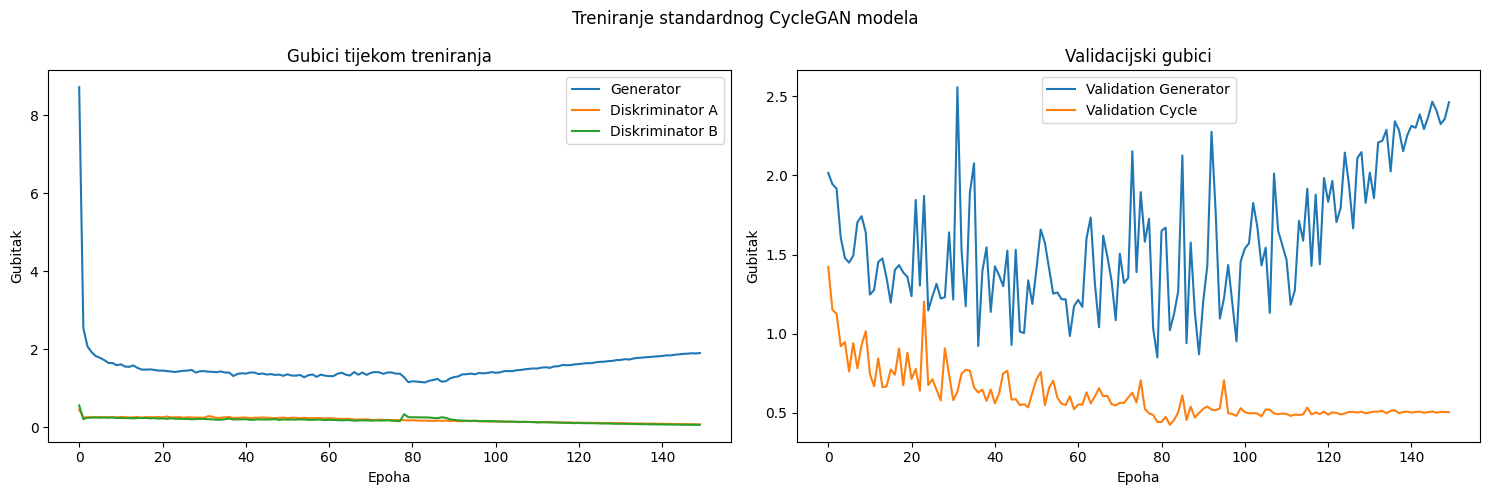

In [9]:
# Vizualizacija krivulja treniranja
plot_training_curves(train_history, "Treniranje standardnog CycleGAN modela")

In [10]:
test_model(G_AB=G_AB, G_BA=G_BA, test_dataloader=test_dataloader, config=config)

Evaluacija modela: 100%|██████████| 22/22 [00:02<00:00,  8.81it/s]


=== Rezultati evaluacije ===
T1 -> T2 translacija:
  SSIM: 0.8287
  MSE: 0.003433
  PSNR: 24.94 dB

T2 -> T1 translacija:
  SSIM: 0.8629
  MSE: 0.003457
  PSNR: 24.91 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.9483
  MSE: 0.000866
  PSNR: 30.80 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.9338
  MSE: 0.001078
  PSNR: 29.84 dB

=== Rezultati evaluacije (fiksni crop) ===
T1 -> T2 translacija:
  SSIM: 0.7370
  MSE: 0.005665
  PSNR: 22.76 dB

T2 -> T1 translacija:
  SSIM: 0.7811
  MSE: 0.005709
  PSNR: 22.73 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.9140
  MSE: 0.001431
  PSNR: 28.62 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.8921
  MSE: 0.001779
  PSNR: 27.67 dB


Vizualizacija rezultata na test setu:


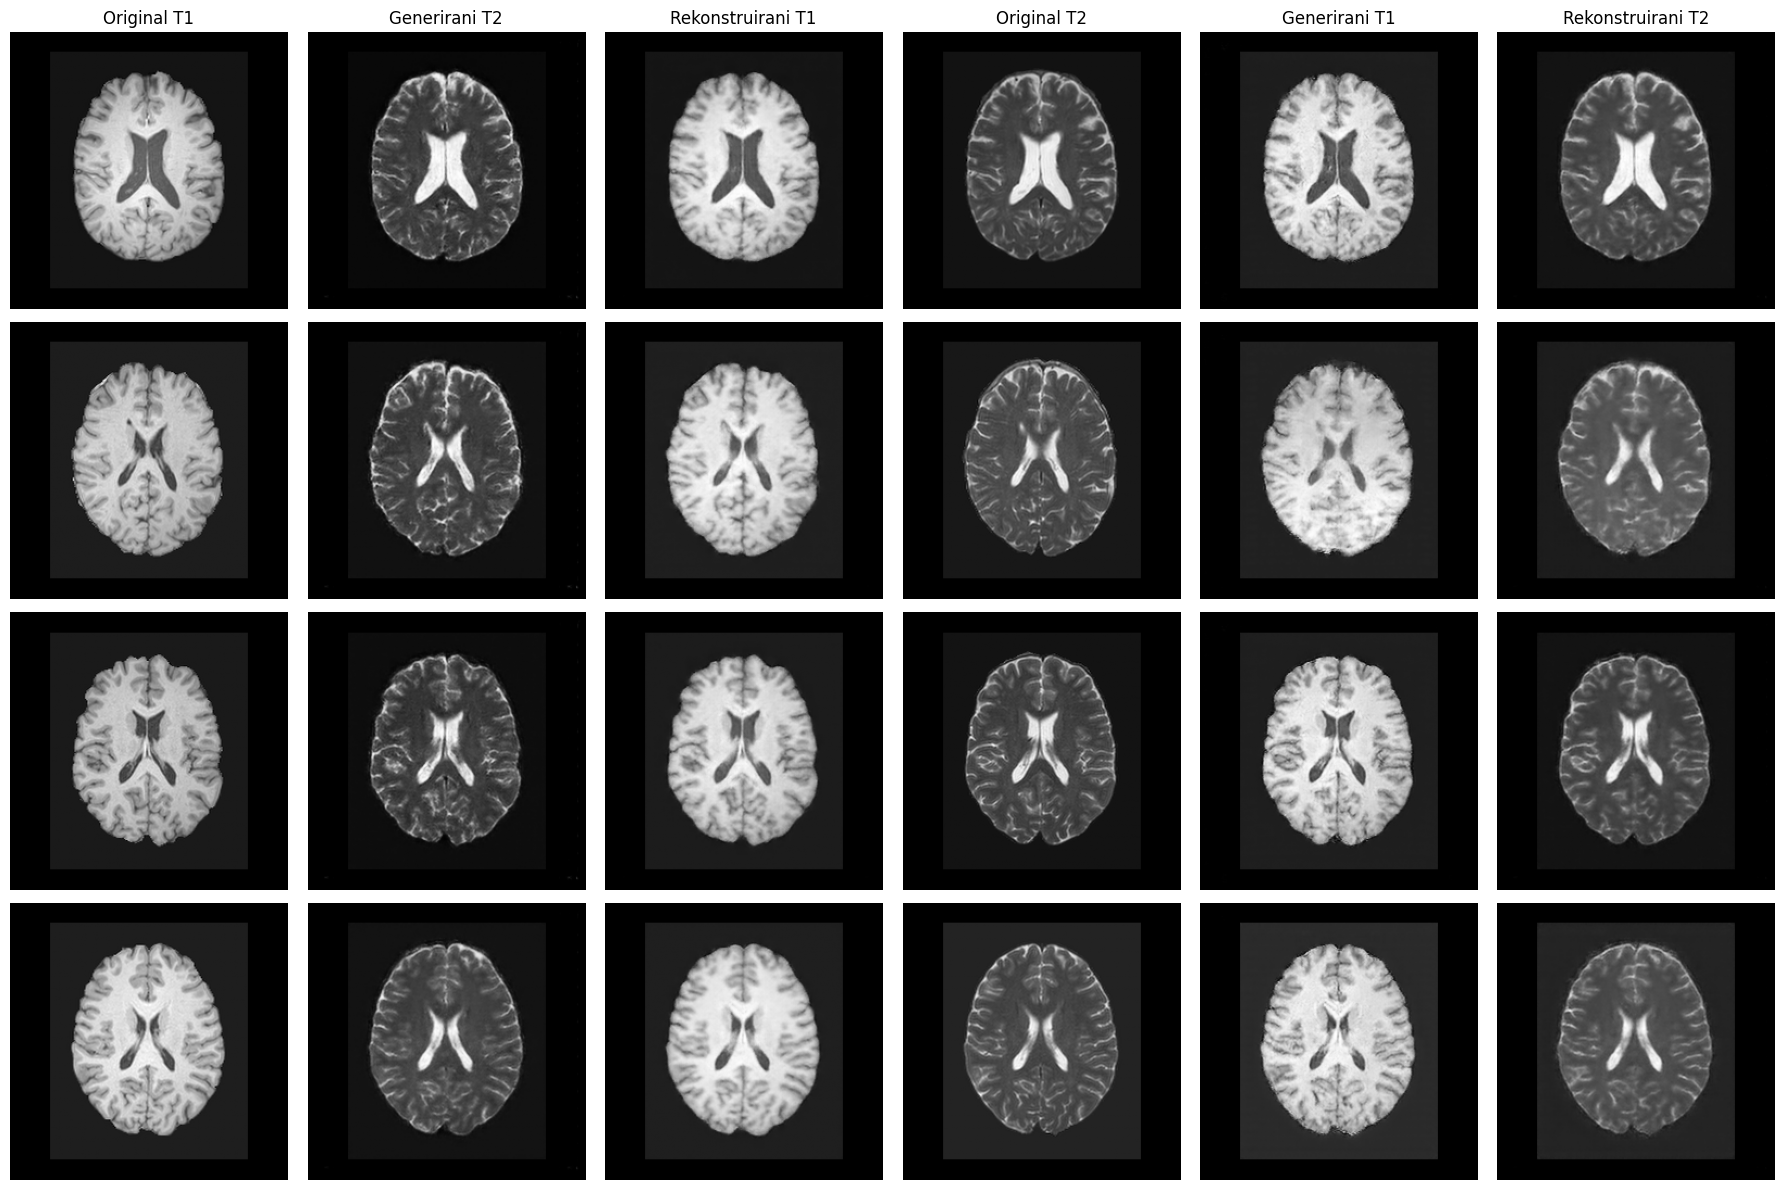

In [11]:
print("Vizualizacija rezultata na test setu:")
visualize_results(G_AB, G_BA, test_dataloader, num_samples=4, config=config)

In [12]:
best_G_AB = UNetGenerator(config.input_channels, config.output_channels, config.ngf).to(config.device)
best_G_BA = UNetGenerator(config.input_channels, config.output_channels, config.ngf).to(config.device)

# Putanje do najboljih modela
best_G_AB_path = f"{config.checkpoints_dir}/G_AB_best.pth"
best_G_BA_path = f"{config.checkpoints_dir}/G_BA_best.pth"
best_G_AB.load_state_dict(torch.load(best_G_AB_path, map_location=config.device))
best_G_BA.load_state_dict(torch.load(best_G_BA_path, map_location=config.device))

<All keys matched successfully>

In [13]:
print("Testiranje najboljih modela:")
test_model(best_G_AB, best_G_BA, test_dataloader, config)

Testiranje najboljih modela:


Evaluacija modela: 100%|██████████| 22/22 [00:02<00:00,  8.73it/s]


=== Rezultati evaluacije ===
T1 -> T2 translacija:
  SSIM: 0.8309
  MSE: 0.003918
  PSNR: 24.30 dB

T2 -> T1 translacija:
  SSIM: 0.8521
  MSE: 0.003814
  PSNR: 24.40 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.9681
  MSE: 0.000510
  PSNR: 33.13 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.9550
  MSE: 0.000761
  PSNR: 31.27 dB

=== Rezultati evaluacije (fiksni crop) ===
T1 -> T2 translacija:
  SSIM: 0.7315
  MSE: 0.006472
  PSNR: 22.12 dB

T2 -> T1 translacija:
  SSIM: 0.7595
  MSE: 0.006299
  PSNR: 22.22 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.9472
  MSE: 0.000842
  PSNR: 30.95 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.9252
  MSE: 0.001257
  PSNR: 29.09 dB


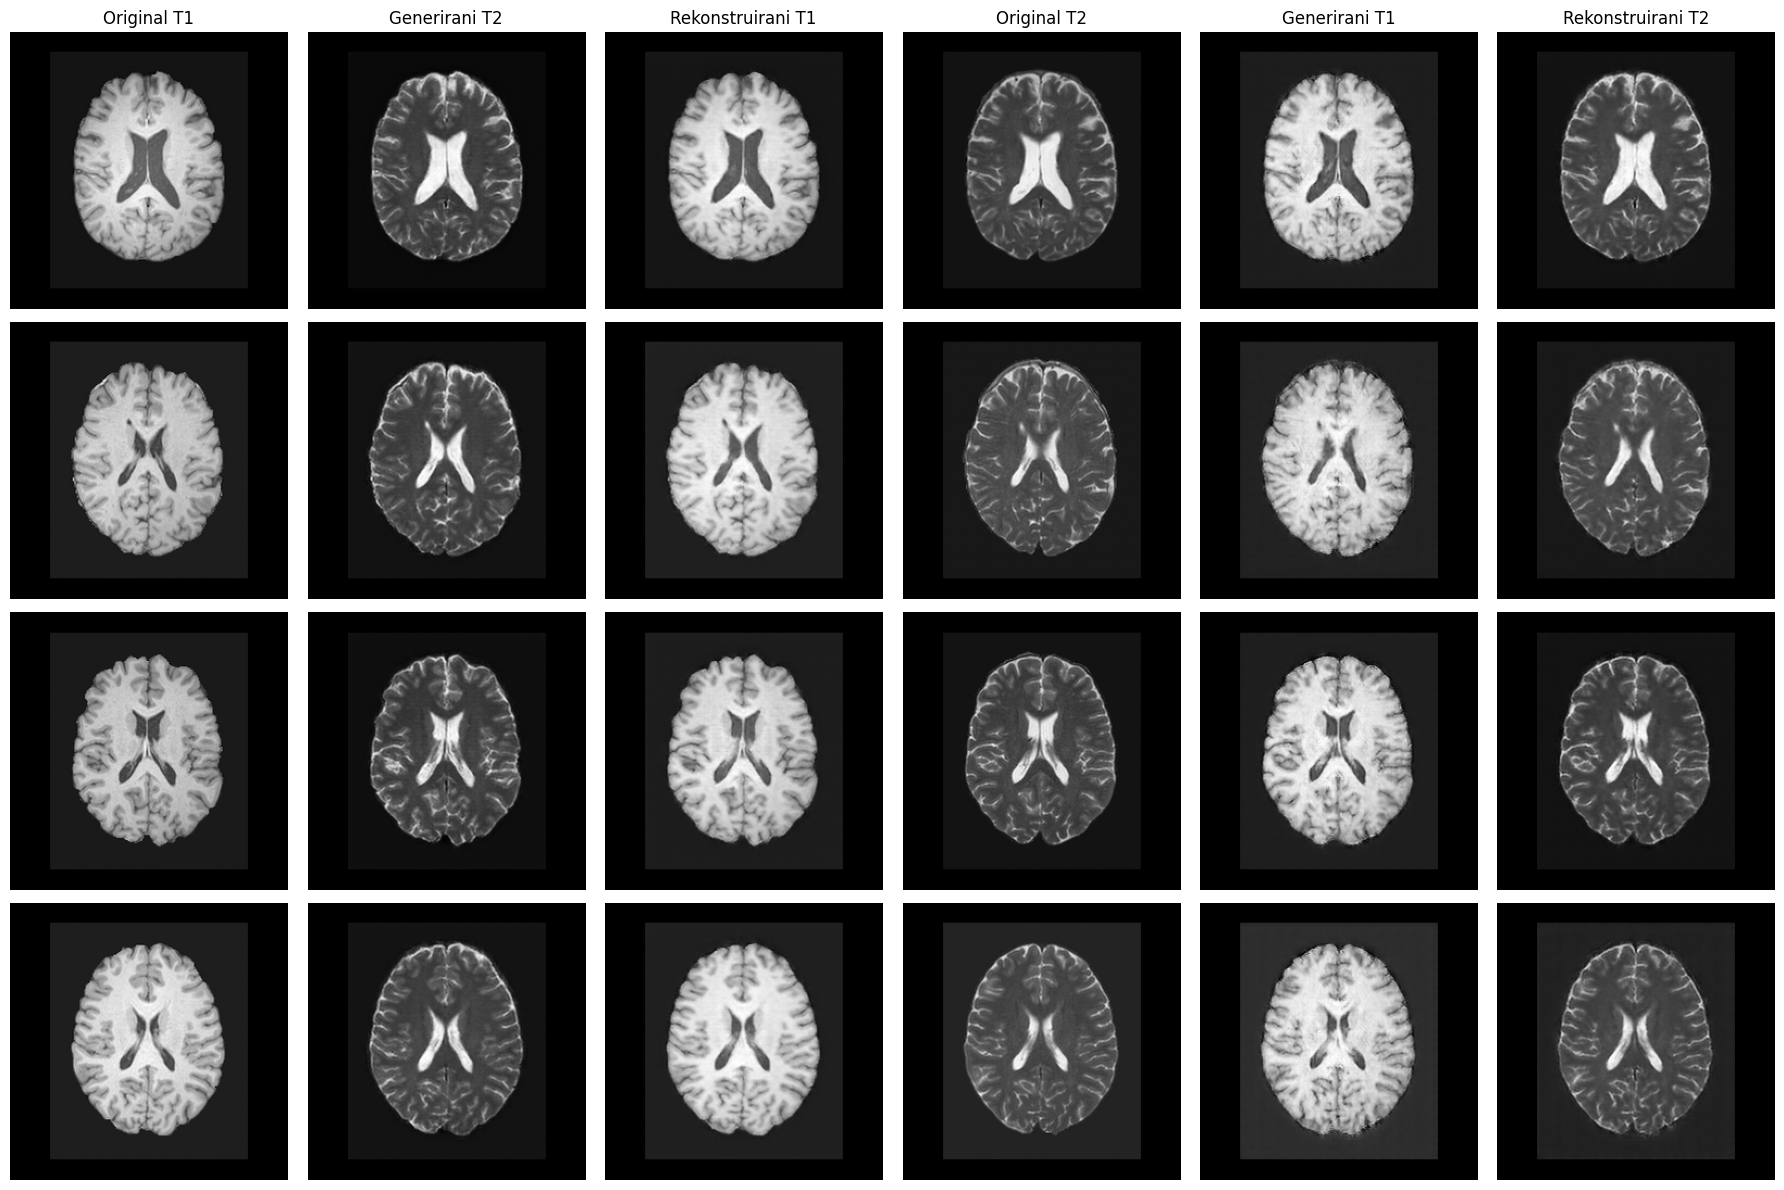

In [14]:
visualize_results(
    best_G_AB, best_G_BA, test_dataloader, num_samples=4, config=config
)